In [291]:
from io import StringIO
from dotenv import load_dotenv

import os
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option("display.max_columns", 50)


In [292]:
aws_access_key_id = os.getenv("AWS_ACCESS_KEY")
aws_secret_key = os.getenv("AWS_SECRET_KEY")

In [293]:
load_dotenv()

True

In [294]:
def read_csv_from_s3(bucket: str, path: str, filename: str) -> pd.DataFrame:
    """Downloads a csv file from an s3 bucket.
    
    Parameters
    ----------
    bucket : str
        The bucket where the files at.
    path : str
        The folders to the file.
    filename : str
        Name of the file.
        
    Returns
    -------
    pd.DataFrame
        A DataFrame of the Downloaded file.
    
    """
    s3 = boto3.client("s3", aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_key)
    
    full_path = f"{path}{filename}"
    
    object = s3.get_object(Bucket = bucket, Key = full_path)
    object = object["Body"].read().decode("utf-8")
    output_df = pd.read_csv(StringIO(object))
    
    return output_df

In [295]:
s3 = boto3.client("s3", aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_key)
bucket = "cubix-chicago-taxi-vti"

community_areas_path = "transformed_data/community_areas/"
company_path = "transformed_data/company/"
date_path = "transformed_data/date/"
payment_type_path = "transformed_data/payment_type/"
taxi_trips_path = "transformed_data/taxi_trips/"
weather_path = "transformed_data/weather/"



In [296]:
community_areas = read_csv_from_s3(bucket, community_areas_path, "community_areas_master.csv")
company = read_csv_from_s3(bucket, company_path, "company_master.csv")
date = read_csv_from_s3(bucket, date_path, "date_dimension.csv")
payment_type = read_csv_from_s3(bucket = bucket, path = payment_type_path, filename = "payment_type_master.csv")

In [297]:
trips_list = []
weather_list = []

In [298]:

for file in s3.list_objects(Bucket = bucket, Prefix = taxi_trips_path)["Contents"]:
    taxi_trip_key = file["Key"]
    
    if taxi_trip_key.split("/") [-1].strip() != "":
        if taxi_trip_key.split(".")[1] == "csv":
            
            filename =  taxi_trip_key.split("/") [-1]
            trip = read_csv_from_s3(bucket, taxi_trips_path, filename)

            trips_list.append(trip)
            print(f"{filename} has been added.")

          
                        

taxi_2024-06-22.csv has been added.
taxi_2024-06-23.csv has been added.
taxi_2024-06-24.csv has been added.
taxi_2024-06-25.csv has been added.
taxi_2024-06-26.csv has been added.
taxi_2024-06-27.csv has been added.
taxi_2024-07-01.csv has been added.


In [299]:
trips = pd.concat(trips_list, ignore_index = True)

In [300]:
trips.shape

(114011, 20)

In [301]:

for file in s3.list_objects(Bucket = bucket, Prefix = weather_path)["Contents"]:
    
    weather_key = file["Key"]
    
    if weather_key.split("/") [-1].strip() != "":
        if weather_key.split(".")[1] == "csv":
        
            filename = weather_key.split("/") [-1]

            weather_daily = read_csv_from_s3(bucket, weather_path, filename)

            weather_list.append(weather_daily)
            print(f"{filename} has been added.")



weather_2024-06-06.csv has been added.
weather_2024-06-07.csv has been added.
weather_2024-06-08.csv has been added.
weather_2024-06-09.csv has been added.
weather_2024-06-10.csv has been added.
weather_2024-06-11.csv has been added.
weather_2024-06-12.csv has been added.
weather_2024-06-13.csv has been added.
weather_2024-06-14.csv has been added.
weather_2024-06-15.csv has been added.
weather_2024-06-16.csv has been added.
weather_2024-06-17.csv has been added.
weather_2024-06-18.csv has been added.
weather_2024-06-19.csv has been added.
weather_2024-06-20.csv has been added.
weather_2024-06-21.csv has been added.
weather_2024-06-22.csv has been added.
weather_2024-06-23.csv has been added.
weather_2024-06-24.csv has been added.
weather_2024-06-25.csv has been added.
weather_2024-06-26.csv has been added.
weather_2024-06-27.csv has been added.


In [302]:
weather = pd.concat(weather_list, ignore_index = True)

In [303]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       528 non-null    object 
 1   temperature    528 non-null    float64
 2   wind_speed     528 non-null    float64
 3   rain           528 non-null    float64
 4   precipitation  528 non-null    float64
dtypes: float64(4), object(1)
memory usage: 20.8+ KB


#### Join them together

In [304]:
trips_full = pd.merge(trips, weather, left_on="datetime_for_weather", right_on="datetime", how ="inner")
trips_full = trips_full.drop(columns=["datetime"])

In [305]:
trips_full = pd.merge(trips_full, company, left_on="company_id", right_on="company_id", how ="inner")
trips_full = trips_full.drop(columns=["company_id"])

In [306]:
trips_full = pd.merge(trips_full, payment_type, left_on="payment_type_id", right_on="payment_type_id", how ="inner")
trips_full = trips_full.drop(columns=["payment_type_id"])

In [307]:
trips_full = pd.merge(trips_full, community_areas, left_on="pickup_community_area_id", right_on="area_code", how ="inner")
trips_full = trips_full.drop(columns=["pickup_community_area_id", "area_code"])
trips_full.rename(columns={"community_name": "pickup_community_area_name"}, inplace=True)

In [308]:
trips_full = pd.merge(trips_full, community_areas, left_on="dropoff_community_area_id", right_on="area_code", how ="inner")
trips_full = trips_full.drop(columns=["dropoff_community_area_id", "area_code"])
trips_full.rename(columns={"community_name": "dropoff_community_area_name"}, inplace=True)

In [309]:
date["date"] = pd.to_datetime(date["date"])
trips_full["trip_start_timestamp"] = pd.to_datetime(trips_full["trip_start_timestamp"])

trips_full["trip_start_date"] = trips_full["trip_start_timestamp"].dt.date
trips_full["trip_start_date"] =pd.to_datetime(trips_full["trip_start_date"])

In [310]:
trips_full = pd.merge(trips_full, date, left_on="trip_start_date", right_on="date", how ="inner")
trips_full = trips_full.drop(columns=["date"])

In [311]:
trips_full.sample(4)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,temperature,wind_speed,rain,precipitation,company,payment_type,pickup_community_area_name,dropoff_community_area_name,trip_start_date,year,month,day,day_of_week,is_weekend
43135,e62dc2a8e1bb0f7d0f2a936ecfc5154594c602c9,9dc01bf146083f56d659b0e783aaa68d61971d562902fb...,2024-06-24 12:30:00,2024-06-24T12:30:00.000,300,0.80,5.50,1.00,0.0,1.0,7.50,41.884987,-87.620993,41.870607,-87.622173,2024-06-24 12:00:00,20.4,6.6,0.0,0.0,Taxi Affiliation Services,Credit Card,Loop,Loop,2024-06-24,2024,6,24,1,False
92966,99892de92690680369bde3cc8fb34f900e99af0f,3edf5aaee7cd5378f854cca9e574820e57badb93344e0c...,2024-06-27 23:30:00,2024-06-27T23:45:00.000,818,4.95,15.50,0.00,0.0,1.0,17.00,41.899602,-87.633308,41.922761,-87.699155,2024-06-27 23:00:00,18.8,15.0,0.0,0.0,Flash Cab,Credit Card,Near North Side,Logan Square,2024-06-27,2024,6,27,4,False
53356,57f1806351f900cea7776fa81194ef3089400bbf,55c17b60024566921288582fe7c79716366093e9966024...,2024-06-25 20:00:00,2024-06-25T20:15:00.000,1638,16.81,42.00,5.00,0.0,5.0,52.50,41.979071,-87.903040,41.892508,-87.626215,2024-06-25 20:00:00,32.8,27.5,0.0,0.0,Sun Taxi,Credit Card,O'Hare,Near North Side,2024-06-25,2024,6,25,2,False
106159,192856619cd378d8264074555df01fabab75ab5f,7b50110eaa441d38f0dba8a06ee13d5cb2854661aafb85...,2024-06-27 12:00:00,2024-06-27T12:00:00.000,655,4.78,13.55,3.33,0.0,0.0,16.88,41.899602,-87.633308,41.965812,-87.655879,2024-06-27 12:00:00,17.2,26.6,0.0,0.0,Medallion Leasin,Mobile,Near North Side,Uptown,2024-06-27,2024,6,27,4,False


#### Visualizations

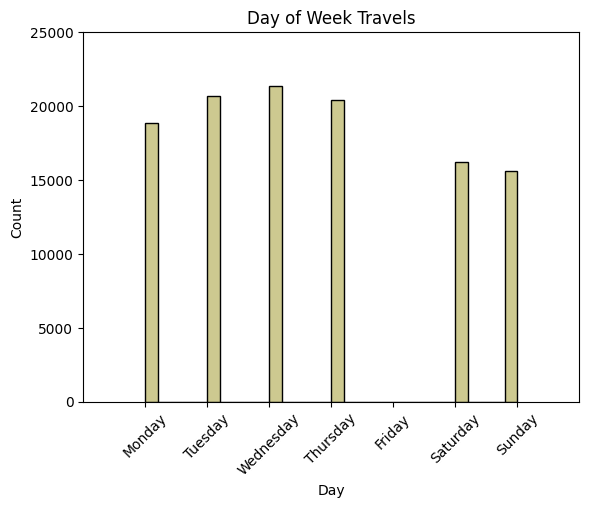

In [312]:
# 1. table Histogram of trips in a week

plot = sns.histplot(trips_full["day_of_week"], color="darkkhaki", bins= 30, kde= False)
plt.title("Day of Week Travels")
plt.xlabel("Day")
plt.ylabel("Count")
plt.xlim(0, 8)
plt.ylim(0, 25000)

day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.xticks(range(1, 8), day_names)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

plt.show()

C:\Users\vtama\AppData\Local\Temp\ipykernel_13536\349002754.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


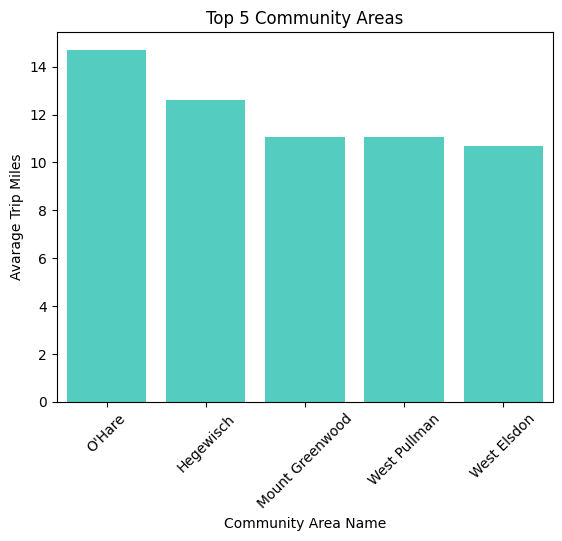

In [313]:
# 2.table Avarage trip miles by top 5 community area

ordered_trips = trips_full.groupby("pickup_community_area_name")["trip_miles"].mean().sort_values(ascending=False)

top_5_areas = ordered_trips.head(5)

plot = sns.barplot(x=top_5_areas.index, y=top_5_areas.values, color= "turquoise")
plt.title("Top 5 Community Areas")
plt.xlabel("Community Area Name")
plt.ylabel("Avarage Trip Miles")

plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

plt.show()

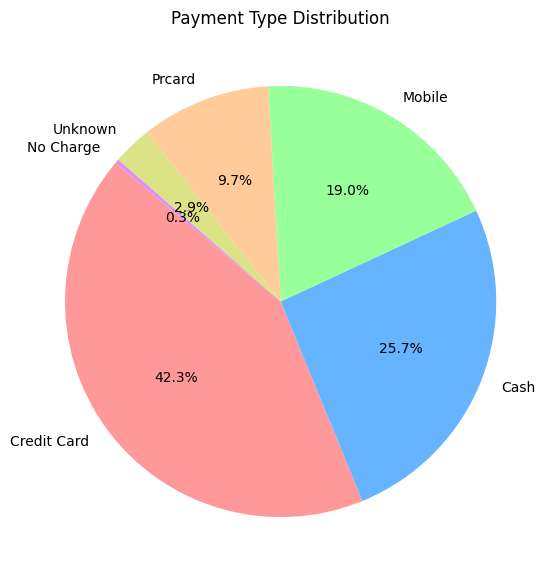

In [314]:
# 3.table Pie chart of payment types

data = trips_full["payment_type"].value_counts()
data = data[data.index != "Dispute"]

colors = ["#ff9999","#66b3ff","#99ff99","#ffcc99","#dbe386","#dd90f5"]


plt.figure(figsize=(7, 7))
plt.pie(data, labels=data.index, autopct="%1.1f%%", startangle=140, colors=colors)


plt.title("Payment Type Distribution")
plt.show()

C:\Users\vtama\AppData\Local\Temp\ipykernel_13536\3692017301.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


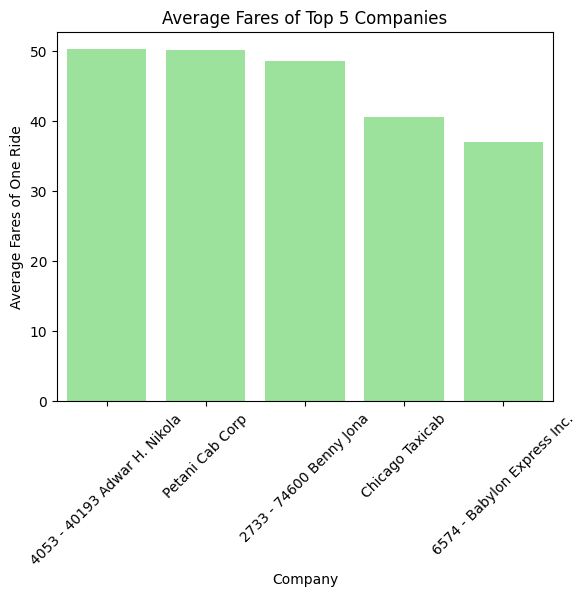

In [315]:
# 4. table Bar chart of top 3 companies and their average fees of rides.

ordered_fares = trips_full.groupby("company")["trip_total"].mean().sort_values(ascending=False)

top_5_companies = ordered_fares.head(5)

plot = sns.barplot(x=top_5_companies.index, y=top_5_companies.values, color="lightgreen")
plt.title("Average Fares of Top 5 Companies")
plt.xlabel("Company")
plt.ylabel("Average Fares of One Ride")

plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

plt.show()

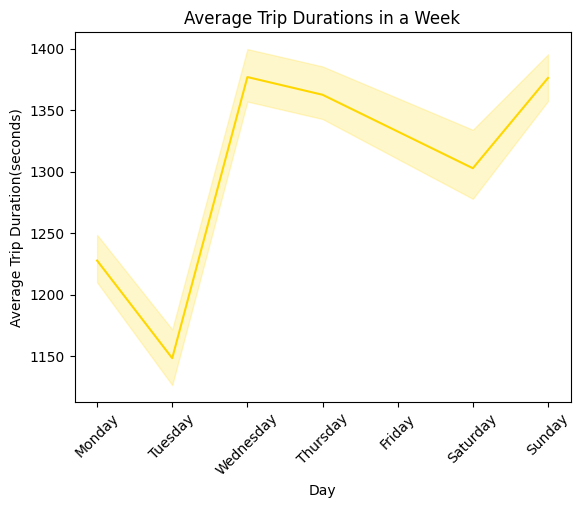

In [316]:
# 5. table trip seconds of a day

plot = sns.lineplot(x="day_of_week", y= "trip_seconds", data= trips_full, color= "gold")
plt.title("Average Trip Durations in a Week")
plt.xlabel("Day")
plt.ylabel("Average Trip Duration(seconds)")

day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.xticks(range(1, 8), day_names)

plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

plt.show()